In [1]:
%load_ext line_profiler

In [324]:
from collections import Counter
from functools import partial

import numpy as np
rng = np.random.default_rng()
np.set_printoptions(suppress=True, linewidth=150, edgeitems=5)
from tqdm.notebook import tqdm, trange
from tqdm.contrib.concurrent import process_map

from scipy.stats import rankdata
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [16]:
# ns = [0,10,10,11,12,13,14,15,16,17]
ns = [0,5,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
ns = [0]


students = np.logspace(-1, 1, 21)
display(students)


ms = 5
arrs = np.triu(np.tile(np.arange(32, 37),(5,1)).T) - 20
display(arrs)
display(arrs.sum())

# ms = 4
# arrs = np.triu(np.tile(np.arange(31, 35),(4,1)).T) - 20
# display(arrs)
# display(arrs.sum())


# ms = 2
# arrs = np.array([[10,-20],[7,3]])
# display(arrs)
# display(arrs.sum())

array([ 0.1       ,  0.12589254,  0.15848932,  0.19952623,  0.25118864,  0.31622777,  0.39810717,  0.50118723,  0.63095734,  0.79432823,  1.        ,
        1.25892541,  1.58489319,  1.99526231,  2.51188643,  3.16227766,  3.98107171,  5.01187234,  6.30957344,  7.94328235, 10.        ])

array([[ 12,  12,  12,  12,  12],
       [-20,  13,  13,  13,  13],
       [-20, -20,  14,  14,  14],
       [-20, -20, -20,  15,  15],
       [-20, -20, -20, -20,  16]])

0

In [4]:
def softmax(x, b, axis=-1):
    x = x - np.max(x)
    return np.exp(b*x) / np.exp(b*x).sum(axis=axis, keepdims=True)

def make_model(num_nodes=128, num_dense=4):
    
    import tensorflow as tf
    for gpu in tf.config.list_physical_devices('GPU'):
        tf.config.experimental.set_memory_growth(gpu, True)
    
    inputs = tf.keras.layers.Input(shape=(ms*ms + ms + 1))
    x = tf.keras.layers.Flatten()(inputs)
    
    for _ in range(num_dense):
        x = tf.keras.layers.Dense(num_nodes, activation='relu')(x)
    
    # output1 = tf.keras.layers.Dense(5, name='Y0')(x)
    # output2 = tf.keras.layers.Dense(5, name='Y1')(x)
    # model = tf.keras.models.Model(inputs=inputs, outputs=[output1, output2])
    
    output1 = tf.keras.layers.Dense(ms, name='Y0')(x)
    output1 = tf.keras.layers.Softmax()(output1)
    model = tf.keras.models.Model(inputs=inputs, outputs=output1)

    
    opt = tf.keras.optimizers.Adam()
    # opt = tf.keras.optimizers.Adam(learning_rate=1)
    # opt = tf.keras.optimizers.SGD()
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])
    return model

def softmax(x, b, axis=-1):
    x = x - np.max(x)
    return np.exp(b*x) / np.exp(b*x).sum(axis=axis, keepdims=True)

def make_x():
    x = arrs
    
    rand = np.random.random(arrs.shape)
    rand = (rand - 0.5)
    x = x + rand
    
    x = rng.permuted(x, axis=-1)
    return x

def eval_model(model, n = 1, disable=True):
    rewards = []
    branch_rewards = []
    for _ in trange(n, disable=disable):
        x = make_x()
        x_tree = np.concatenate([np.eye(ms+1).astype(int), np.tile(x.flatten(), (ms+1,1))], axis=1)
        y_pred = model(x_tree)
        branch_reward = (x_tree[0,ms+1:].reshape(ms,ms) * y_pred[1:].numpy()).sum(axis=1)
        rewards.append(y_pred[0].numpy())
        # reward = (y_pred[0] * branch_reward).numpy().sum()
        # rewards.append(reward)
        branch_rewards.append(branch_reward)
    return np.array(rewards), np.array(branch_rewards)

def make_data(b, n=1, disable=True):
    X, Y = [], []
    
    
    for _ in trange(n, disable=disable):
        x = make_x()
        r1 = softmax(rankdata(x,axis=1), b)
        r1sum = (r1*x).sum(axis=1)
        r0 = softmax(rankdata(r1sum), b)

        pos = [0] * (ms+1)
        pos[0] = 1
        x0 = pos + list(x.flatten())
        y0 = rng.choice(np.arange(ms), p=r0)
        
        pos = [0] * (ms+1)
        pos[y0+1] = 1
        x1 = pos + list(x.flatten())
        y1 = rng.choice(np.arange(ms), p=r1[y0])


        X.append(x0)
        Y.append(y0)
        X.append(x1)
        Y.append(y1)
    
    X = np.array(X)
    Y = np.array(Y)
    
    return X,Y

In [5]:
def train_model(student):
    verbose = False
    if student == students[len(students)//2]:
        print(f'student == {student:.3f}')
        verbose = True
    model = make_model()
    Xtrain, Ytrain = make_data(student, 2**18, disable=not verbose)
    model.fit(Xtrain, Ytrain, verbose=verbose)
    reward = eval_model(model, 10000, disable=not verbose)
    model.save(f'models/starting_{student:.3f}.keras')
    return reward

In [6]:
%%time
rewards = process_map(train_model, students, disable=True, max_workers=12)

student == 1.000


  0%|          | 0/262144 [00:00<?, ?it/s]

16384/16384 [==============================] - 90s 5ms/step - loss: 1.3008 - accuracy: 0.3953


  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 2.52 s, sys: 2.19 s, total: 4.72 s
Wall time: 9min 11s


In [7]:
for r, s in zip(rewards, students):
    
    res = r[0]*r[1]
    res = res.sum(axis=1).mean()
    
    print(f"{s:.3f} {res}")

0.100 0.6047144456320354
0.126 0.898265843647721
0.158 0.9345544215203754
0.200 1.3101098403539695
0.251 2.702475342986951
0.316 3.5366761497111483
0.398 4.715843282595216
0.501 6.059887200589628
0.631 7.231318549006592
0.794 9.416961929094725
1.000 11.43735109538131
1.259 11.17735924698972
1.585 12.933823626528195
1.995 13.851843312419675
2.512 14.371955318278015
3.162 14.631933463019546
3.981 15.215875328019084
5.012 15.695674134611783
6.310 15.84285634287316
7.943 15.958879423349877
10.000 16.000269590905354


In [8]:
%%time
for b in students:
    r0s = []
    r1s = []
    for _ in trange(10000, disable=True):
        x = make_x()
        r1 = (softmax(x, b) * x).sum(axis=1)
        r2 = (softmax(r1, b) * r1).sum()
        
        r1 = softmax(rankdata(x,axis=1), b)
        r1sum = (r1*x).sum(axis=1)
        r0 = softmax(rankdata(r1sum), b)
        r0sum = (r0*r1sum).sum()

        
        r0s.append(r0sum)
        r1s.append(r1sum)
        
    r0s = np.array(r0s)
    r1s = np.array(r1s)
    print(f"{b:.3f}, {r0s.mean():.3f}, {r1s.mean(axis=0)}")


0.100, 2.546, [ 12.0311079    7.67267364   2.40994092  -3.86381898 -11.27512371]
0.126, 3.167, [ 12.03971628   7.97598963   2.91496731  -3.30681855 -10.86185564]
0.158, 3.922, [ 12.05140022   8.34572821   3.53201308  -2.60739755 -10.32990745]
0.200, 4.826, [12.06415655  8.78603274  4.28639069 -1.73329105 -9.6479045 ]
0.251, 5.885, [12.0810113   9.30095259  5.1997323  -0.64147889 -8.77523525]
0.316, 7.082, [12.10067977  9.88714417  6.276888    0.69087694 -7.66098517]
0.398, 8.372, [12.12278343 10.53267146  7.5107583   2.29761683 -6.24560535]
0.501, 9.664, [12.15375275 11.2009743   8.86140137  4.1751447  -4.48076057]
0.631, 10.826, [12.18307243 11.84520108 10.25880562  6.27402841 -2.3332664 ]
0.794, 11.775, [12.21328159 12.3969981  11.57031287  8.46002583  0.18653165]
1.000, 12.556, [12.24271682 12.80946045 12.66743023 10.55546134  2.98191248]
1.259, 13.259, [12.26767376 13.07214567 13.44869817 12.33692912  5.89090937]
1.585, 13.843, [12.29149368 13.20332022 13.90984382 13.65432888  8.68

In [30]:
def eval_training(student, teacher, verbose=False):
    import tensorflow as tf
    for gpu in tf.config.list_physical_devices('GPU'):
        tf.config.experimental.set_memory_growth(gpu, True)

    
    if student == -1:
        model2 = make_model()
    else:
        model2 = tf.keras.models.load_model(f"models/starting_{student:.3f}.keras")
    # opt = tf.keras.optimizers.SGD()
    opt = tf.keras.optimizers.Adam()
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    model2.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])
    # print(f"{b:.2f}", end=':    ')
    nsum = 0
    
    X, Y = currs[f"{teacher:.3f}"]
    perm = np.random.permutation(len(X))
    X, Y = X[perm], Y[perm]
    
    rewards = []
    for i in ns:
        if i != 0:
            n = 2**i
            # X, Y = make_data(teacher, n, disable=True)
                        
            model2.fit(X[nsum:nsum+n], Y[nsum:nsum+n], verbose=False)
            nsum += n
            
        r0, r1 = eval_model(model2, 10)
        reward = (r0*r1).sum(axis=1).mean()
        rewards.append(reward)
        # print(f"{nsum}    ", end='\r')
    return rewards

In [160]:
import tensorflow as tf
for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)
tf.get_logger().setLevel('ERROR')



In [42]:
model2 = tf.keras.models.load_model(f"models/starting_{0.100:.3f}.keras")

In [63]:
%timeit r0, r1 = eval_model(model2, 1)

2.85 ms ± 151 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [165]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(CustomCallback, self).__init__()

    def on_batch_end(self, batch, logs=None):
        r0, r1 = eval_model(self.model, 10)
        r = (r0*r1).sum(axis=1).mean()
        
        
        try:
            self.model.rewards.append(r)
            self.model.accs.append(logs['accuracy'])
        except:
            self.model.rewards = [r]
            self.model.accs = [logs['accuracy']]

#         # Add the output to the logs
#         if logs is not None:
#             logs['reward'] = r

In [310]:
models = {}

In [ ]:
%%time

with open('tree.log', 'a') as f:
    for student in students[::2][:6]:
        
        print(f'student {student:.3f}', file=f, flush=True)

        models[student] = {}

        for teacher in students[::2][3:10]:

            print(f'teacher {teacher:.3f}', file=f, flush=True)
            models[student][teacher] = []
            for i in range(5):
                print(f'model {i}', file=f, flush=True)
                # model = make_model()
                model = tf.keras.models.load_model(f"models/starting_{student:.3f}.keras")

                opt = tf.keras.optimizers.Adam()
                loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
                model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])

                X, Y = currs[f'{teacher:.3f}']
                model.fit(X[:2**17], Y[:2**17], callbacks=[CustomCallback()], verbose=False)
                # model.fit(X[:2**17], Y[:2**17], callbacks=[CustomCallback()])

                models[student][teacher].append(model)


        #         break
        #     break
        # break

Student 0.100


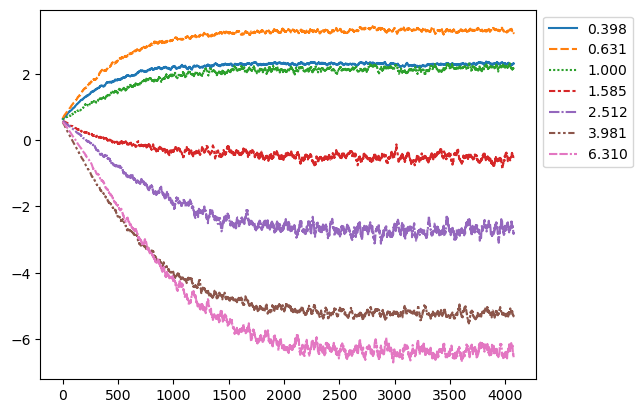


Student 0.158


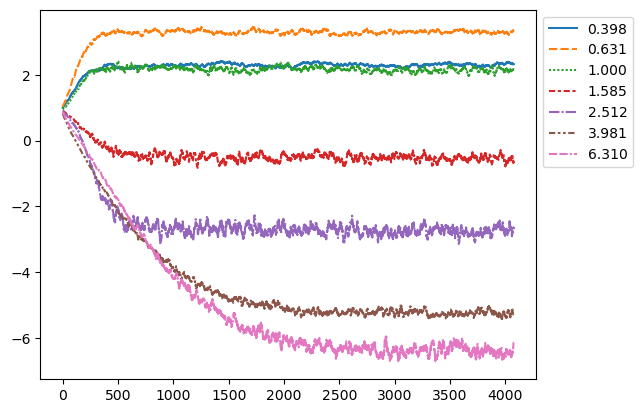


Student 0.251


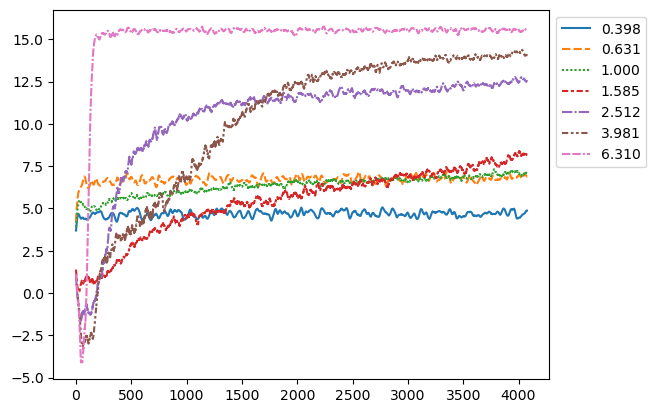


Student 0.398


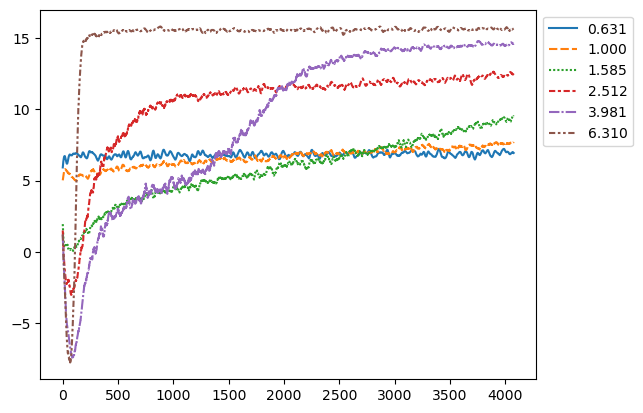


Student 0.631


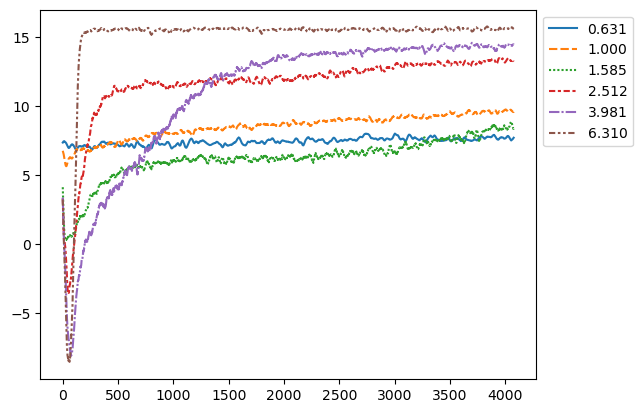


Student 1.000


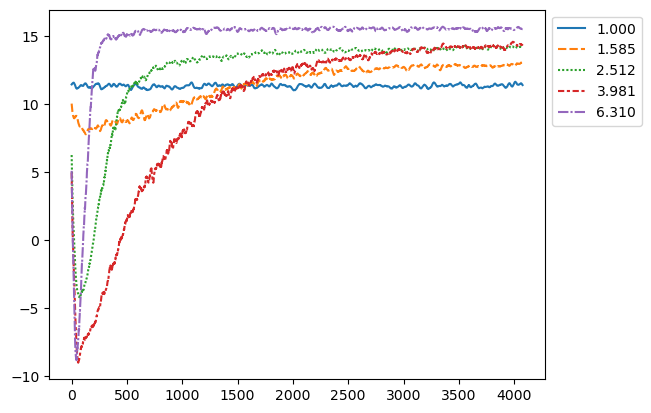

In [331]:
for student, s_models in models.items():
    # print(student, list(s_models))
    df = {}
    for teacher, model in s_models.items():
        kernel_size = 20
        kernel = np.ones(kernel_size) / kernel_size
        rewards = np.array([m.rewards for m in model]).mean(axis=0)
        rewards = np.convolve(rewards, kernel, mode='valid')
        df[f"{teacher:.3f}"] = rewards
    df = pd.DataFrame(df)
    
    print(f'Student {student:.3f}')
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        ax = sns.lineplot(df[[c for c in df.columns if float(c) >= student]])
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
        plt.show()
    print()

In [329]:
df[[c for c in df.columns if float(c) >= 1]]

,1.000,1.585,2.512,3.981,6.310
0,11.466422,10.053075,6.265203,4.979628,5.097481
1,11.479920,9.957407,5.824776,4.399943,4.524793
2,11.494202,9.854896,5.392818,3.826452,3.977680
3,11.505109,9.767417,4.941007,3.266981,3.420427
4,11.507618,9.676994,4.511967,2.736340,2.870953
...,...,...,...,...,...
4072,11.468142,13.109564,14.154775,14.376295,15.545305
4073,11.457409,13.115538,14.157460,14.383872,15.542761
4074,11.447501,13.112964,14.161488,14.392318,15.543083
4075,11.437604,13.124171,14.162638,14.414110,15.547582


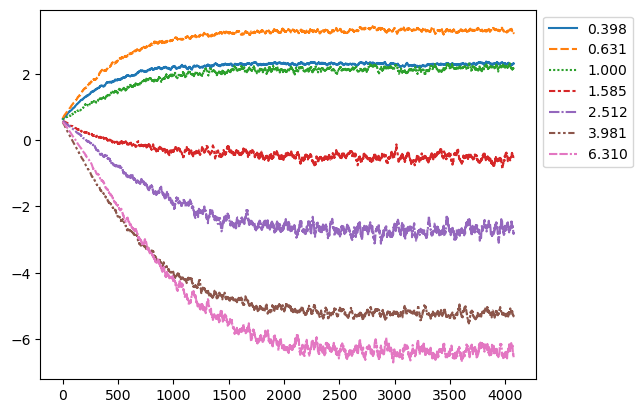

In [321]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

    ax = sns.lineplot(df)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [ ]:
1+1

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

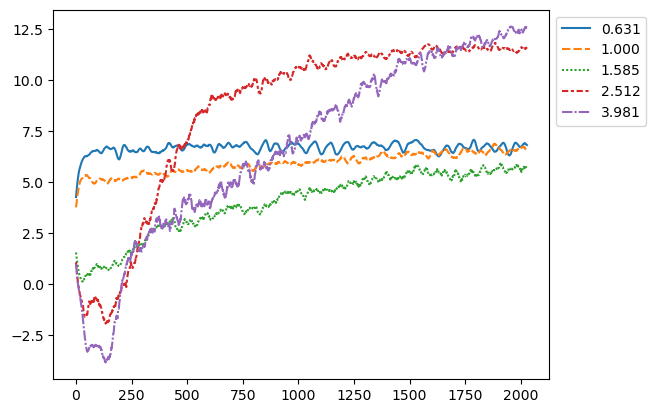

In [282]:
ax = sns.lineplot(df[df.columns[4:9]])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [286]:
students[::2][4:9]

array([0.63095734, 1.        , 1.58489319, 2.51188643, 3.98107171])

In [6]:
def exp(student, verbose=True, n=20):
    # teachers = np.arange(student, 0.40001, 0.02)
    
    teachers = students
    
    t_ = list(teachers) * n
    s_ = [student for _ in t_]
    
    res = process_map(eval_training, s_, t_, max_workers=32, chunksize=1)
    
    return np.array(res)

#     all_res = []
#     for teacher in tqdm(teachers):
        
#         if teacher == teachers[0] and verbose:
#             print(f'Original Student: {student:.3f}')
#             print()
#             print('         Curriculum Size')
#             print('Teacher', end='')
#             nsum = 0
#             for i in ns:
#                 if i: nsum += 2**i
#                 print(f"{nsum:>8}", end='')
#             print()
        
#         # print(f"teacher = {teacher:.2f} ", end='\r')
#         res = process_map(eval_training, [student]*n, [teacher]*n, max_workers=10, disable=True)
#         res = np.array(res).mean(axis=0)
#         all_res.append(res)
        
#         if verbose:
#             print(f"  {teacher:.3f}", end='  ')
#             for reward in res:
#                 print(f"{reward: 6.2f}", end='  ')
#             print()

#     all_res = np.array(all_res)

    # return all_res

In [7]:
%%time
ntotal = (2**np.array(ns[1:])).sum()

currs = process_map(make_data, students, [ntotal]*len(students), max_workers=6, chunksize=1)
currs = dict(zip([f"{s:.3f}" for s in students], currs))

  0%|          | 0/21 [00:00<?, ?it/s]

CPU times: user 4.52 s, sys: 10.3 s, total: 14.8 s
Wall time: 39min 28s


In [19]:
%%time
exp(-1, n=1).reshape(-1, len(students), len(ns)).mean(axis=0).round(2)

  0%|          | 0/21 [00:00<?, ?it/s]

CPU times: user 49.4 ms, sys: 1.42 s, total: 1.47 s
Wall time: 10 s


array([[10.01],
       [ 6.93],
       [ 7.65],
       [ 8.59],
       [-0.92],
       [ 1.79],
       [-8.79],
       [-1.06],
       [-4.16],
       [13.91],
       [ 8.85],
       [11.32],
       [ 1.3 ],
       [ 2.07],
       [ 0.36],
       [10.14],
       [ 1.66],
       [-2.48],
       [ 7.88],
       [-1.21],
       [-2.38]])

In [8]:
%%time
# compiled
foo_new = exp(-1, n=1)
foo_new.reshape(-1, len(students), len(ns)).mean(axis=0).round(2)

  0%|          | 0/21 [00:00<?, ?it/s]

CPU times: user 64.1 ms, sys: 1.38 s, total: 1.45 s
Wall time: 5min 38s


array([[  4.65,   4.44,   3.72,  -4.81,   0.62,   1.71,   0.56,   0.24,   0.49,   0.19,   0.62,   0.74,   0.4 ,   0.58,   0.6 ,   0.58,   0.66],
       [  8.05,   6.07,   3.25,  -4.18,   0.63,   1.05,  -0.12,   0.04,   0.25,   0.86,   1.1 ,   0.18,   0.84,   0.98,   0.79,   0.84,   0.81],
       [ -2.84,  -2.43,   2.44,   2.38,  -0.53,   1.31,  -0.72,   2.71,   0.8 ,   0.66,   0.63,   0.96,   1.24,   0.97,   0.81,   1.03,   0.99],
       [  9.49,   2.17,  -3.2 ,  -4.52,   6.49,   0.75,  -1.34,   1.34,   1.05,   1.41,   1.39,   1.14,   1.21,   1.09,   1.13,   1.22,   1.18],
       [  0.15,  -0.08,   1.91,   3.52,   1.96,   3.07,   1.21,   2.79,   1.16,   1.16,   2.42,   1.08,   1.3 ,   1.3 ,   1.51,   1.47,   1.59],
       [-10.74,  -2.71,   5.49,   7.13,   3.11,  -0.57,   2.01,   2.58,   1.67,   0.37,   2.09,   2.02,   1.8 ,   2.48,   4.43,   3.9 ,   4.15],
       [  1.8 ,   1.57,   1.34,   2.  ,  -0.41,   2.8 ,   2.53,   1.44,   1.38,   1.24,   1.56,   2.35,   2.6 ,   5.38,   5.3 ,   

In [9]:
%%time
# compiled
foo0100 = exp(0.1, n=1)
foo0100.reshape(-1, len(students), len(ns)).mean(axis=0).round(2)

  0%|          | 0/21 [00:00<?, ?it/s]

CPU times: user 61.6 ms, sys: 1.34 s, total: 1.4 s
Wall time: 5min 37s


array([[ 0.64,  0.64,  0.62,  0.66,  0.64,  0.62,  0.65,  0.57,  0.53,  0.56,  0.52,  0.51,  0.67,  0.72,  0.57,  0.73,  0.61],
       [ 0.64,  0.64,  0.62,  0.66,  0.65,  0.64,  0.67,  0.61,  0.58,  0.65,  0.65,  0.68,  0.8 ,  0.82,  0.69,  0.76,  0.81],
       [ 0.64,  0.64,  0.62,  0.66,  0.65,  0.64,  0.68,  0.64,  0.63,  0.74,  0.79,  0.87,  1.03,  1.  ,  0.86,  1.13,  1.08],
       [ 0.64,  0.64,  0.62,  0.66,  0.65,  0.64,  0.71,  0.68,  0.69,  0.9 ,  0.96,  1.07,  1.26,  1.32,  1.21,  1.24,  1.22],
       [ 0.64,  0.64,  0.62,  0.65,  0.65,  0.65,  0.72,  0.71,  0.76,  1.01,  1.2 ,  1.3 ,  1.62,  1.63,  1.48,  1.54,  1.56],
       [ 0.64,  0.64,  0.61,  0.65,  0.65,  0.65,  0.74,  0.76,  0.85,  1.18,  1.43,  1.61,  1.9 ,  2.01,  1.75,  1.8 ,  1.87],
       [ 0.64,  0.64,  0.62,  0.67,  0.66,  0.67,  0.78,  0.83,  0.96,  1.41,  1.72,  2.04,  2.34,  2.35,  2.26,  2.24,  2.17],
       [ 0.64,  0.64,  0.62,  0.67,  0.67,  0.68,  0.79,  0.88,  1.03,  1.54,  1.97,  2.43,  2.9 ,  2.85

In [10]:
%%time
# compiled
foo0158 = exp(0.158, n=1)
foo0158.reshape(-1, len(students), len(ns)).mean(axis=0).round(2)

  0%|          | 0/21 [00:00<?, ?it/s]

CPU times: user 54.9 ms, sys: 1.55 s, total: 1.6 s
Wall time: 5min 38s


array([[ 0.97,  0.96,  0.95,  1.  ,  0.98,  0.93,  0.93,  0.79,  0.71,  0.69,  0.56,  0.57,  0.6 ,  0.63,  0.63,  0.68,  0.65],
       [ 0.97,  0.96,  0.95,  1.  ,  0.99,  0.95,  0.96,  0.84,  0.77,  0.79,  0.7 ,  0.68,  0.76,  0.96,  0.7 ,  0.75,  0.7 ],
       [ 0.97,  0.96,  0.95,  1.  ,  1.  ,  0.96,  1.  ,  0.88,  0.83,  0.9 ,  0.86,  0.89,  0.93,  0.98,  0.88,  0.92,  0.96],
       [ 0.97,  0.96,  0.95,  1.01,  1.  ,  0.98,  1.04,  0.96,  0.94,  1.05,  1.02,  1.07,  1.29,  1.34,  1.12,  1.19,  1.3 ],
       [ 0.97,  0.96,  0.95,  1.01,  1.  ,  0.98,  1.06,  1.01,  1.05,  1.3 ,  1.39,  1.27,  1.48,  1.49,  1.46,  1.53,  1.48],
       [ 0.97,  0.96,  0.95,  1.  ,  1.  ,  0.98,  1.1 ,  1.12,  1.23,  1.58,  1.71,  1.71,  2.05,  1.99,  1.84,  1.86,  1.93],
       [ 0.97,  0.97,  0.96,  1.03,  1.03,  1.03,  1.18,  1.25,  1.51,  2.13,  2.12,  2.14,  2.46,  2.2 ,  2.43,  2.32,  2.43],
       [ 0.97,  0.97,  0.96,  1.03,  1.04,  1.04,  1.23,  1.37,  1.68,  2.48,  2.55,  2.57,  2.89,  2.97

In [11]:
%%time
# compiled
foo0251 = exp(0.251, n=1)
foo0251.reshape(-1, len(students), len(ns)).mean(axis=0).round(2)

  0%|          | 0/21 [00:00<?, ?it/s]

CPU times: user 59.2 ms, sys: 1.53 s, total: 1.59 s
Wall time: 5min 38s


array([[ 2.72,  2.66,  2.67,  2.36,  2.05,  2.04,  1.97,  1.33,  1.15,  1.08,  1.41,  0.96,  0.94,  0.74,  0.92,  0.99,  1.02],
       [ 2.72,  2.66,  2.67,  2.39,  2.11,  2.13,  2.11,  1.55,  1.69,  1.47,  1.38,  0.95,  1.19,  1.43,  1.18,  1.51,  1.6 ],
       [ 2.72,  2.73,  2.76,  2.54,  2.45,  2.65,  2.5 ,  2.04,  1.79,  1.56,  1.47,  1.78,  1.6 ,  1.38,  2.1 ,  2.13,  1.84],
       [ 2.72,  2.73,  2.77,  2.59,  2.62,  2.87,  2.95,  2.26,  2.68,  2.54,  2.  ,  2.22,  2.41,  2.06,  2.05,  2.68,  2.2 ],
       [ 2.72,  2.83,  2.98,  2.95,  3.21,  3.61,  3.14,  2.83,  3.2 ,  2.57,  3.04,  2.87,  3.42,  3.51,  2.46,  3.16,  2.97],
       [ 2.72,  2.87,  3.09,  3.07,  3.36,  3.88,  3.77,  3.81,  4.33,  4.39,  3.99,  3.57,  3.62,  3.66,  3.44,  4.38,  4.08],
       [ 2.72,  2.9 ,  3.17,  3.19,  3.33,  4.01,  4.35,  5.11,  5.09,  4.64,  4.86,  4.72,  4.83,  4.33,  4.22,  4.85,  5.3 ],
       [ 2.72,  2.91,  3.21,  3.36,  3.79,  4.58,  5.3 ,  6.09,  5.05,  5.74,  5.16,  5.98,  5.8 ,  6.2 

In [12]:
%%time
# compiled
foo0398 = exp(0.398, n=1)
foo0398.reshape(-1, len(students), len(ns)).mean(axis=0).round(2)

  0%|          | 0/21 [00:00<?, ?it/s]

CPU times: user 55.5 ms, sys: 1.48 s, total: 1.54 s
Wall time: 5min 38s


array([[ 4.68,  4.47,  4.21,  3.78,  2.98,  1.95,  1.72,  1.51,  1.05,  1.05,  1.41,  1.19,  1.07,  1.43,  0.83,  1.21,  1.17],
       [ 4.68,  4.47,  4.21,  3.8 ,  3.14,  2.08,  2.32,  1.48,  1.76,  1.61,  1.63,  1.59,  1.45,  1.54,  1.72,  1.45,  1.32],
       [ 4.68,  4.49,  4.24,  3.85,  3.21,  2.14,  2.41,  2.6 ,  1.86,  1.79,  1.84,  1.65,  1.88,  2.1 ,  1.71,  1.66,  2.11],
       [ 4.68,  4.49,  4.24,  3.86,  3.33,  2.78,  3.19,  2.84,  2.67,  2.69,  2.51,  2.2 ,  2.49,  2.51,  2.45,  2.58,  2.53],
       [ 4.68,  4.56,  4.36,  4.05,  3.73,  2.98,  3.68,  3.52,  3.07,  2.69,  2.73,  2.56,  3.1 ,  3.08,  2.84,  3.15,  2.88],
       [ 4.68,  4.83,  4.74,  4.55,  4.25,  3.74,  4.3 ,  4.08,  3.38,  3.84,  3.29,  4.05,  4.14,  3.84,  3.85,  3.47,  4.03],
       [ 4.68,  4.91,  4.95,  4.87,  4.73,  4.99,  4.74,  5.07,  4.77,  4.97,  5.16,  5.61,  5.21,  5.41,  4.12,  5.01,  5.33],
       [ 4.68,  4.96,  5.14,  5.44,  5.59,  5.76,  5.51,  6.08,  5.12,  5.8 ,  5.46,  6.4 ,  6.14,  6.04

In [13]:
%%time
# compiled
foo0631 = exp(0.631, n=1)
foo0631.reshape(-1, len(students), len(ns)).mean(axis=0).round(2)

  0%|          | 0/21 [00:00<?, ?it/s]

CPU times: user 70 ms, sys: 1.4 s, total: 1.47 s
Wall time: 5min 38s


array([[ 7.14,  7.07,  6.83,  6.35,  5.57,  4.08,  0.88,  0.56,  0.76,  0.73,  0.83,  0.83,  1.24,  1.17,  1.14,  1.14,  1.24],
       [ 7.14,  7.07,  6.83,  6.34,  5.54,  3.9 ,  1.55,  1.12,  1.05,  1.07,  1.07,  1.31,  1.68,  1.32,  0.96,  1.56,  1.72],
       [ 7.14,  7.08,  6.86,  6.38,  5.46,  4.3 ,  2.45,  2.07,  1.69,  1.77,  2.04,  1.96,  2.16,  1.91,  1.97,  1.97,  1.97],
       [ 7.14,  7.08,  6.86,  6.38,  5.55,  4.34,  3.06,  2.17,  2.11,  2.32,  2.62,  2.27,  2.49,  2.73,  2.31,  2.43,  2.47],
       [ 7.14,  7.09,  6.89,  6.53,  5.97,  4.91,  4.35,  3.98,  3.47,  3.23,  3.39,  3.68,  2.82,  2.54,  2.53,  2.93,  3.4 ],
       [ 7.14,  7.16,  7.01,  6.67,  6.18,  5.31,  5.22,  4.49,  4.36,  4.16,  3.74,  3.57,  3.9 ,  4.52,  4.24,  4.39,  4.63],
       [ 7.14,  7.15,  6.96,  6.57,  6.06,  5.52,  5.04,  5.01,  5.07,  5.48,  4.77,  5.14,  4.56,  5.05,  4.98,  5.31,  5.63],
       [ 7.14,  7.2 ,  7.13,  6.83,  6.4 ,  6.13,  6.1 ,  6.13,  6.4 ,  5.55,  5.63,  6.18,  6.14,  6.44

In [14]:
%%time
# compiled
foo1000 = exp(1.000, n=1)
foo1000.reshape(-1, len(students), len(ns)).mean(axis=0).round(2)

  0%|          | 0/21 [00:00<?, ?it/s]

CPU times: user 58.9 ms, sys: 1.54 s, total: 1.6 s
Wall time: 5min 37s


array([[11.42, 11.1 , 10.8 , 10.27,  8.61,  6.11,  3.18,  2.61,  1.65,  1.19,  1.55,  1.24,  1.24,  1.29,  1.26,  0.9 ,  1.29],
       [11.42, 11.1 , 10.81, 10.27,  8.58,  6.64,  3.45,  2.37,  1.64,  1.64,  1.97,  1.63,  1.16,  1.78,  1.64,  1.63,  1.22],
       [11.42, 11.1 , 10.83, 10.31,  8.78,  7.14,  3.81,  3.39,  2.14,  2.18,  2.54,  2.36,  2.08,  2.4 ,  2.04,  1.86,  1.74],
       [11.42, 11.1 , 10.85, 10.39,  9.29,  7.46,  4.43,  3.81,  2.92,  3.08,  2.85,  2.9 ,  2.37,  2.81,  2.58,  3.04,  3.31],
       [11.42, 11.13, 10.93, 10.55,  9.35,  7.27,  6.46,  4.94,  3.84,  3.69,  3.95,  3.94,  3.5 ,  3.66,  3.72,  4.42,  4.48],
       [11.42, 11.14, 10.96, 10.57,  9.42,  8.4 ,  7.07,  5.31,  5.65,  5.8 ,  4.89,  4.7 ,  4.24,  5.2 ,  4.84,  4.48,  5.33],
       [11.42, 11.07, 10.83, 10.4 ,  9.68,  8.87,  7.37,  6.46,  6.79,  6.45,  6.44,  6.38,  4.32,  5.86,  6.82,  6.59,  7.05],
       [11.42, 11.11, 10.83, 10.48,  9.69,  8.4 ,  7.21,  7.61,  7.95,  8.08,  8.03,  7.88,  8.3 ,  7.39

In [15]:
%%time
# compiled
foo1585 = exp(1.585, n=1)
foo1585.reshape(-1, len(students), len(ns)).mean(axis=0).round(2)

  0%|          | 0/21 [00:00<?, ?it/s]

CPU times: user 64.1 ms, sys: 1.35 s, total: 1.42 s
Wall time: 5min 37s


array([[ 13.  ,  13.13,  12.6 ,  11.81,   9.82,   8.4 ,   4.66,   2.27,   1.46,   1.17,   1.05,   1.24,   0.76,   1.21,   0.66,   0.93,   0.99],
       [ 13.  ,  13.13,  12.6 ,  11.87,   9.76,   8.44,   4.39,   2.44,   1.51,   2.1 ,   1.41,   1.13,   1.85,   1.7 ,   1.31,   2.3 ,   1.61],
       [ 13.  ,  13.13,  12.63,  11.99,  10.18,   8.78,   5.14,   2.69,   1.77,   1.95,   2.48,   2.03,   2.66,   1.94,   1.44,   1.97,   1.7 ],
       [ 13.  ,  13.13,  12.61,  11.91,  10.36,   8.65,   4.34,   3.02,   2.17,   2.81,   3.05,   2.94,   2.38,   2.76,   2.04,   2.76,   2.89],
       [ 13.  ,  13.16,  12.72,  12.08,  10.18,   8.06,   5.  ,   4.  ,   4.21,   3.59,   4.47,   3.41,   4.09,   3.77,   3.69,   4.15,   3.55],
       [ 13.  ,  13.15,  12.66,  11.77,  10.17,   7.86,   5.48,   3.59,   5.68,   5.08,   5.76,   4.77,   4.85,   4.75,   4.39,   4.76,   4.8 ],
       [ 13.  ,  13.09,  12.49,  11.66,   9.86,   7.88,   6.32,   4.56,   6.13,   6.36,   5.79,   6.25,   5.86,   5.84,   6.15,   

In [ ]:
%%time
# compiled
foo2512 = exp(2.512, n=5)
foo2512.reshape(-1, len(students), len(ns)).mean(axis=0).round(2)

In [ ]:
%%time
# compiled
foo3981 = exp(3.981, n=5)
foo3981.reshape(-1, len(students), len(ns)).mean(axis=0).round(2)

In [ ]:
%%time
# compiled
foo6310 = exp(6.310, n=5)
foo6310.reshape(-1, len(students), len(ns)).mean(axis=0).round(2)